# Preprocessing, GridSearch and Training SpiderNet-8 on Private Data

In [1]:
import numpy as np
from numpy import array
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import math

import matplotlib.pylab as plt
from matplotlib.pyplot import cm
import seaborn as sns
import itertools
import collections
from collections import OrderedDict, Counter

import scipy.stats as stats
from scipy.stats import normaltest, kstest, ttest_ind, ttest_rel, mannwhitneyu, wilcoxon, levene, bartlett
from scipy.stats import chi2_contingency, fisher_exact, mode, pearsonr, f_oneway, kruskal, spearmanr

from rfpimp import *

from datetime import datetime
import re
from seaborn import heatmap
import random
import statsmodels.distributions.empirical_distribution as edf
from scipy.interpolate import interp1d

from sklearn.utils import resample
from functools import reduce
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

from sklearn import metrics, preprocessing
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, log_loss, recall_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, PowerTransformer

from sklearn.utils import check_consistent_length, column_or_1d, assert_all_finite
from sklearn.utils.extmath import stable_cumsum
from sklearn.utils.multiclass import type_of_target
from sklearn.linear_model import LogisticRegression
import re
import gc
import os

from statsmodels.stats.proportion import proportions_ztest

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import pathlib
import psutil

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
PATH_DATA = 'D:/Share/01 -Risk Desc Science/AntiFraud/Data Sets/'
PATH = 'D:/Share/safanasev/Python-notebook/AF_ML_v2_2014_2019/'
print(PATH_DATA)
print(PATH)

D:/Share/01 -Risk Desc Science/AntiFraud/Data Sets/
D:/Share/safanasev/Python-notebook/AF_ML_v2_2014_2019/


In [3]:
task = 'binary'
missing_strings = 'MISSING'
p_value = 0.05
target_dict = {'good': 0, 'bad': 1}

In [4]:
target = 'BAD_FLAG'
index_month = 'MONTH_YEAR'
list_of_vars_for_strat = ['MONTH_YEAR']
sort_by_var = 'APPPOSID'

necessary_fields = [target, index_month, sort_by_var]

COL_DEL = ['Unnamed: 0', 'PERIOD_7', 'LOSS_90P']
COL_DEL = [x.upper() for x in COL_DEL]
COL_TRG = target

In [5]:
COL_DEL

['UNNAMED: 0', 'PERIOD_7', 'LOSS_90P']

In [6]:
necessary_fields

['BAD_FLAG', 'MONTH_YEAR', 'APPPOSID']

## Loading preprocessing data

In [65]:
PATH

'D:/Share/safanasev/Python-notebook/AF_ML_v2_2014_2019/'

In [66]:
train_for = pd.read_csv(PATH + 'train_163_prep.csv')
valid_for = pd.read_csv(PATH + 'valid_163_prep.csv')
test_for = pd.read_csv(PATH + 'test_163_prep.csv')

In [73]:
PATH + 'train_163_prep.csv', PATH + 'test_163_prep.csv'

('D:/Share/safanasev/Python-notebook/AF_ML_v2_2014_2019/train_163_prep.csv',
 'D:/Share/safanasev/Python-notebook/AF_ML_v2_2014_2019/test_163_prep.csv')

In [9]:
y_train = train_for[target]
y_test = valid_for[target]
y_val = test_for[target]

train_for.drop('Unnamed: 0', axis=1, inplace=True)
valid_for.drop('Unnamed: 0', axis=1, inplace=True)
test_for.drop('Unnamed: 0', axis=1, inplace=True)


col = train_for.columns.to_list()
col.remove(target)


X_1_2 = train_for[col]
X_2_2 = valid_for[col]
X_3_2 = test_for[col]

In [10]:
x_col = X_2_2.columns
y_col = 'BAD_FLAG'

In [11]:
from keras.utils import np_utils

In [12]:
Y_test_2 = np_utils.to_categorical( y_test, 2)

In [39]:
#check correctness
X_1_2.shape,  X_2_2.shape, Y_test_2.shape

((1507599, 163), (185400, 163), (185400, 2))

## Loading public preprocessing data

In [48]:
target = 'LABEL'
index_month = 'MONTH'
list_of_vars_for_strat = ['MONTH']
sort_by_var = 'ID'

necessary_fields = [target, index_month, sort_by_var]

COL_DEL = ['Unnamed: 0'] 
COL_DEL = [x.upper() for x in COL_DEL]
COL_TRG = target

In [49]:
PATH = 'D:/Share/safanasev/Python-notebook/AF_ML_chinese/'
train_for = pd.read_csv(PATH + 'china_train_128_prep.csv')
valid_for = pd.read_csv(PATH + 'china_val_128_prep.csv')
test_for = pd.read_csv(PATH + 'china_test_128_prep.csv')

In [50]:
y_train = train_for[target]
y_val = valid_for[target]
y_test = test_for[target]

train_for.drop('Unnamed: 0', axis = 1, inplace = True)
valid_for.drop('Unnamed: 0', axis = 1, inplace = True)
test_for.drop('Unnamed: 0', axis = 1, inplace = True)


col = train_for.columns.to_list()
col.remove(target)


X_1_2 = train_for[col]
X_2_2 = valid_for[col]
X_3_2 = test_for[col]

In [51]:
x_col = X_2_2.columns
y_col = 'LABEL'

## Loading tensorflow

In [14]:
from tensorflow.keras.layers import (
    Input, Activation, Dense, Flatten, Dropout)
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, AveragePooling1D)
from tensorflow.keras.layers import add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

In [15]:
from tensorflow.keras.layers import ReLU, Concatenate, GlobalAveragePooling1D

In [16]:
from keras.utils import np_utils
from tensorflow.keras.models import Model

In [17]:
import tensorflow as tf

In [18]:
print(tf.__version__)

2.3.0


In [19]:
from tensorflow.keras.callbacks import EarlyStopping, Callback, LearningRateScheduler


class E_time(Callback):
    def on_train_begin(self, logs={}):
        tm = datetime.strftime(datetime.now(), "%d.%m.%Y %H:%M:%S")
        print('train_begin', '| time: ', tm)

    def on_epoch_end(self, epoch, logs={}):
        tm = datetime.strftime(datetime.now(), "%d.%m.%Y %H:%M:%S")
        print('epoch_end', '| time: ', tm)

        return


_time = E_time()

In [20]:
# DataGenerator is used to adjust the bad rate in each batch

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self,  dataset, x_col, y_col,  batch_size=256, num_classes=2, alpha=0.1, random_state=42,
                 shuffle=True, class_w=None):
        self.batch_size = batch_size
        self.dataset = dataset
        self.x_col = x_col
        self.y_col = y_col
        self.indices = self.dataset.index.tolist()
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.alpha = alpha
        self.random_state = random_state
        self.class_w = class_w
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.indices) / self.batch_size)

    def __getitem__(self, index):
        index = self.index[index *
                           self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]

        data_tmp = self.dataset.loc[batch]
        data_tmp_b = data_tmp[data_tmp[self.y_col] == 1]
        data_tmp_b_all = self.dataset[self.dataset[self.y_col] == 1]
        X_tmp = data_tmp.head(0)

        if (self.alpha is None) and (self.class_w is None):
            X = data_tmp[self.x_col]
            y = data_tmp[self.y_col]

        elif (self.alpha is None) and self.class_w > 0:
            k = (self.class_w*self.batch_size)/(1-self.class_w)
            k = k - data_tmp_b.shape[0]
            if int(k) < 1:
                k = k+1
            ix2 = np.random.RandomState(
                self.random_state + int(k)).choice(data_tmp_b_all.shape[0], int(k))
            X_tmp = data_tmp_b_all.iloc[ix2]
            data_tmp = data_tmp.append(X_tmp, ignore_index=True)
            X = data_tmp[self.x_col]
            y = data_tmp[self.y_col]

        else:
            if data_tmp_b.shape[0] > 0:
                k = (self.alpha*self.batch_size /
                     data_tmp_b.shape[0] - 1)/(1-self.alpha)
                for i in range(0, int(k)):
                    X_tmp = X_tmp.append(data_tmp_b, ignore_index=True)
            else:
                k = (self.alpha*self.batch_size)/(1-self.alpha)
                ix2 = np.random.RandomState(
                    self.random_state + int(k)).choice(data_tmp_b_all.shape[0], int(k))
                X_tmp = data_tmp_b_all.iloc[ix2]
                data_tmp_b = X_tmp

            k_fraction = k - int(k)
            n_samples = int(round(data_tmp_b.shape[0]*k_fraction))

            ix = np.random.RandomState(self.random_state).choice(
                data_tmp_b.shape[0], n_samples)
            data_add_fraction = data_tmp_b.iloc[ix]
            X_tmp.append(data_add_fraction, ignore_index=True)

            data_tmp = data_tmp.append(X_tmp, ignore_index=True)

            X = data_tmp[self.x_col]
            y = data_tmp[self.y_col]

        if self.num_classes > 1:
            y = np_utils.to_categorical(y, self.num_classes)

        return [np.array(X)], np.array(y)

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

In [40]:
class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = self.model.predict(self.validation_data[0])[:, 1]
        val_targ = self.validation_data[1]
        
        if len(val_targ.shape) == 2: #and val_targ.shape[1] != 1:
            val_targ = val_targ[:,1]

        _val_aps = metrics.average_precision_score(val_targ, val_predict)
        #_val_recall = metrics.recall_score(val_targ, val_predict)
        _val_a = metrics.roc_auc_score(val_targ, val_predict)

        logs['val_aps'] = _val_aps
        logs['val_a'] = _val_a
        print(" — val_aps:  %f — val_a: %f" % (_val_aps, _val_a))
        return

In [21]:
# Seed value
import tensorflow as tf
import numpy as np
import random
import os
seed_value = 29

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.compat.v1.set_random_seed(seed_value)


# 5. Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

## SpiderNet-6

In [22]:
from tensorflow.keras.layers import GlobalMaxPooling1D

In [23]:
def max_pool(min_pool, n_pool, padding_pool, str_pool, y):
    if y.shape[1] < (min_pool):

        return MaxPooling1D(pool_size=n_pool, padding=padding_pool, strides=1)(y)
    else:
        return MaxPooling1D(pool_size=n_pool, padding=padding_pool, strides=str_pool)(y)

In [24]:
def spider_model(l2_conv=None, reg=1E-5,
                 _bias=True,  n_features=163, n_pool=2, n_kernel=5, n_filters=5, n_strides=1,
                 classes=2, hidden=64, drop_out=0.25, drop_out_conv=0.001, drop_out_rate=4,
                 padding_pool='valid',
                 gl_pool_max=False):

    if reg == None:
        l2_batch_gamma = None
        l2_batch_betta = None
    else:
        l2_batch_gamma = l2(reg)
        l2_batch_betta = l2(reg)

    x = Input(shape=(n_features, 1))
    n = 0
    y = Conv1D(filters=n_filters, kernel_size=n_kernel, strides=n_strides, padding='same',
               use_bias=_bias, kernel_regularizer=l2_conv)(x)

    y = BatchNormalization(gamma_regularizer=l2_batch_gamma,
                           beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y = MaxPooling1D(pool_size=n_pool, padding=padding_pool)(y)
    shortcut1_2 = MaxPooling1D(
        pool_size=n_pool, padding=padding_pool)(y)  # поправить
    shortcut1_3 = MaxPooling1D(
        pool_size=n_pool, padding=padding_pool)(shortcut1_2)
    shortcut1_4 = MaxPooling1D(
        pool_size=n_pool, padding=padding_pool)(shortcut1_3)
    shortcut1_5 = MaxPooling1D(
        pool_size=n_pool, padding=padding_pool)(shortcut1_4)

    # второй spider-block
    y = Conv1D(filters=n_filters*2, kernel_size=n_kernel, strides=n_strides, padding='same',
               use_bias=_bias, kernel_regularizer=l2_conv)(y)
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma,
                           beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y = MaxPooling1D(pool_size=n_pool, padding=padding_pool)(y)
    shortcut2_2 = MaxPooling1D(pool_size=n_pool, padding=padding_pool)(y)
    shortcut2_3 = MaxPooling1D(
        pool_size=n_pool, padding=padding_pool)(shortcut2_2)
    shortcut2_4 = MaxPooling1D(
        pool_size=n_pool, padding=padding_pool)(shortcut2_3)

    y = Concatenate(axis=-1)([shortcut1_2, y])
    n = n+1

    # третий spider-block
    y = Conv1D(filters=n_filters*(3 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
               use_bias=_bias, kernel_regularizer=l2_conv)(y)
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma,
                           beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y = MaxPooling1D(pool_size=n_pool, padding=padding_pool)(y)
    shortcut3_2 = MaxPooling1D(pool_size=n_pool, padding=padding_pool)(y)
    shortcut3_3 = MaxPooling1D(
        pool_size=n_pool, padding=padding_pool)(shortcut3_2)

    y = Concatenate(axis=-1)([shortcut2_2, shortcut1_3, y])
    n = n+1
    # четвертый spider-block
    y = Conv1D(filters=n_filters*(4 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
               use_bias=_bias, kernel_regularizer=l2_conv)(y)
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma,
                           beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y = MaxPooling1D(pool_size=n_pool, padding=padding_pool)(y)
    shortcut4_2 = MaxPooling1D(pool_size=n_pool, padding=padding_pool)(y)

    y = Concatenate(axis=-1)([shortcut3_2, shortcut2_3, shortcut1_4, y])
    n = n+1
    if drop_out_rate is not None:
        y = Dropout(drop_out_conv*(n**drop_out_rate))(y)
        print(n, drop_out_conv*(n**drop_out_rate))
    else:
        print('without dropout conv')

    # пятый spider-block
    y = Conv1D(filters=n_filters*(5 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
               use_bias=_bias, kernel_regularizer=l2_conv)(y)
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma,
                           beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y = MaxPooling1D(pool_size=n_pool, padding=padding_pool)(y)
    y = Concatenate(
        axis=-1)([shortcut4_2, shortcut3_3, shortcut2_4, shortcut1_5, y])
    n = n+1
    if drop_out_rate is not None:
        y = Dropout(drop_out_conv*(n**drop_out_rate))(y)
        print(n, drop_out_conv*(n**drop_out_rate))
    else:
        print('without dropout conv')

    # шестой spider-block
    y = Conv1D(filters=n_filters*(6 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
               use_bias=_bias, kernel_regularizer=l2_conv)(y)
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma,
                           beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)
    if gl_pool_max:
        z = GlobalMaxPooling1D()(y)

    else:
        z = GlobalAveragePooling1D()(y)

    z = Dense(hidden, activation='relu')(z)
    z = Dropout(drop_out)(z)
    z = Dense(hidden, activation='relu')(z)
    z = Dropout(drop_out)(z)
    predictions = Dense(classes, activation='softmax')(z)

    model_15 = Model(inputs=x, outputs=predictions)

    return model_15

In [26]:
def spider_model_8block(l2_conv = None, reg = 1E-5 , reg_dense = 1E-5,
                 _bias = True,  n_features = 163, n_pool = 2, n_kernel = 5, n_filters = 5, n_strides = 1,
                 classes = 2, hidden = 64 , drop_out = 0.25, drop_out_conv = 0.001, drop_out_rate = 4 ,
                 padding_pool = 'valid' ,
                gl_pool_max = False,
                       min_pool = 12, str_pool = None):
    
    if reg == None:
        l2_batch_gamma = None 
        l2_batch_betta = None
    else:
        l2_batch_gamma = l2(reg)
        l2_batch_betta =l2(reg)
    
    if reg_dense == None:
        kernel_regularizer = None
    else:
        kernel_regularizer = l2(reg)   
    
    
    x = Input(shape=(  n_features, 1))
    n = -2 # для 6 - n = 0, для 8 = -2
    y = Conv1D(filters=n_filters, kernel_size=n_kernel, strides=n_strides, padding='same', 
           use_bias=_bias, kernel_regularizer=l2_conv)(x) 

    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)
#y = Dropout(rate=drop_rate)(y)

    y = max_pool(min_pool, n_pool, padding_pool, str_pool, y) ##
    shortcut1_2 = max_pool(min_pool, n_pool, padding_pool, str_pool, y)## поправить
    shortcut1_3 = max_pool(min_pool, n_pool, padding_pool, str_pool, shortcut1_2)##
    shortcut1_4 = max_pool(min_pool, n_pool, padding_pool, str_pool, shortcut1_3)##
    
    shortcut1_5 = max_pool(min_pool, n_pool, padding_pool, str_pool, shortcut1_4)
    shortcut1_6 = max_pool(min_pool, n_pool, padding_pool, str_pool, shortcut1_5) #*
    shortcut1_7 = max_pool(min_pool, n_pool, padding_pool, str_pool, shortcut1_6) #*

    # второй spider-block
    y = Conv1D(filters=n_filters*2, kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y = max_pool(min_pool, n_pool, padding_pool, str_pool, y) ##
    shortcut2_3 = max_pool(min_pool, n_pool, padding_pool, str_pool, y)##
    shortcut2_4 = max_pool(min_pool, n_pool, padding_pool, str_pool, shortcut2_3)##
    
    shortcut2_5 = max_pool(min_pool, n_pool, padding_pool, str_pool, shortcut2_4)
    shortcut2_6 = max_pool(min_pool, n_pool, padding_pool, str_pool, shortcut2_5)
    shortcut2_7 = max_pool(min_pool, n_pool, padding_pool, str_pool, shortcut2_6)


    y= Concatenate(axis=-1)([shortcut1_2, y])
    n = n+1

    # третий spider-block
    y = Conv1D(filters=n_filters*(3 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y = max_pool(min_pool, n_pool, padding_pool, str_pool, y) ##
    shortcut3_4 = max_pool(min_pool, n_pool, padding_pool, str_pool, y)##
    
    shortcut3_5 = max_pool(min_pool, n_pool, padding_pool, str_pool, shortcut3_4)##
    shortcut3_6 = max_pool(min_pool, n_pool, padding_pool, str_pool, shortcut3_5)##
    shortcut3_7 = max_pool(min_pool, n_pool, padding_pool, str_pool, shortcut3_6)##

    y= Concatenate(axis=-1)([shortcut2_3, shortcut1_3, y])
    
    n = n+1
    # четвертый spider-block
    y = Conv1D(filters=n_filters*(4 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y = max_pool(min_pool, n_pool, padding_pool, str_pool, y) ##
    shortcut4_5 = max_pool(min_pool, n_pool, padding_pool, str_pool, y)##
    shortcut4_6 = max_pool(min_pool, n_pool, padding_pool, str_pool, shortcut4_5)##
    shortcut4_7 = max_pool(min_pool, n_pool, padding_pool, str_pool, shortcut4_6)##

    y= Concatenate(axis=-1)([shortcut3_4, shortcut2_4, shortcut1_4, y])
    n = n+1
    if drop_out_rate is not None:
        y = Dropout(drop_out_conv*(n**drop_out_rate))(y)
        print(n, drop_out_conv*(n**drop_out_rate))
    else:
        print('without dropout conv')

    # пятый spider-block
    y = Conv1D(filters=n_filters*(5 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y = max_pool(min_pool, n_pool, padding_pool, str_pool, y) ##
    shortcut5_6 = max_pool(min_pool, n_pool, padding_pool, str_pool, y)
    shortcut5_7 = max_pool(min_pool, n_pool, padding_pool, str_pool, shortcut5_6)    
    
    
    y= Concatenate(axis=-1)([shortcut4_5, shortcut3_5, shortcut2_5, shortcut1_5, y])
    n = n+1
    if drop_out_rate is not None:
        y = Dropout(drop_out_conv*(n**drop_out_rate))(y)
        print(n, drop_out_conv*(n**drop_out_rate))
    else:
        print('without dropout conv')

    # шестой spider-block
    y = Conv1D(filters=n_filters*(6 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)
    
    y = max_pool(min_pool, n_pool, padding_pool, str_pool, y) ##
    shortcut6_7 = max_pool(min_pool, n_pool, padding_pool, str_pool, y)
    
    y= Concatenate(axis=-1)([shortcut5_6, shortcut4_6, shortcut3_6, shortcut2_6, shortcut1_6, y])
    n = n+1
    if drop_out_rate is not None:
        y = Dropout(drop_out_conv*(n**drop_out_rate))(y)
        print(n, drop_out_conv*(n**drop_out_rate))
    else:
        print('without dropout conv')
    
    
    # седьмой блок
    y = Conv1D(filters=n_filters*(7 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)
    
    y = max_pool(min_pool, n_pool, padding_pool, str_pool, y) ##
    
    y= Concatenate(axis=-1)([shortcut6_7, shortcut5_7, shortcut4_7, shortcut3_7, shortcut2_7, shortcut1_7, y])
    n = n+1
    if drop_out_rate is not None:
        y = Dropout(drop_out_conv*(n**drop_out_rate))(y)
        print(n, drop_out_conv*(n**drop_out_rate))
    else:
        print('without dropout conv')
            
    
     # восьмой блок
    y = Conv1D(filters=n_filters*(8 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)
    
    y = max_pool(min_pool, n_pool, padding_pool, str_pool, y) ##
    
    if gl_pool_max:
        z = GlobalMaxPooling1D()(y)
        
    else:
        z = GlobalAveragePooling1D()(y)
    #z = Flatten()(y) #сглаживание, пример использования - https://stackoverflow.com/questions/43237124/what-is-the-role-of-flatten-in-keras
    z = Dense(hidden, activation='relu', kernel_regularizer = kernel_regularizer)(z)
    z = Dropout(drop_out)(z)
    z = Dense(hidden, activation='relu', kernel_regularizer = kernel_regularizer)(z)
    z = Dropout(drop_out)(z)
    predictions = Dense(classes, activation='softmax')(z)

    #model = Sequential()
    model_15 = Model(inputs=x, outputs=predictions)
    
    return model_15

In [27]:
import os
os.environ["PATH"] += os.pathsep + 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\'

without dropout conv
without dropout conv
without dropout conv
without dropout conv


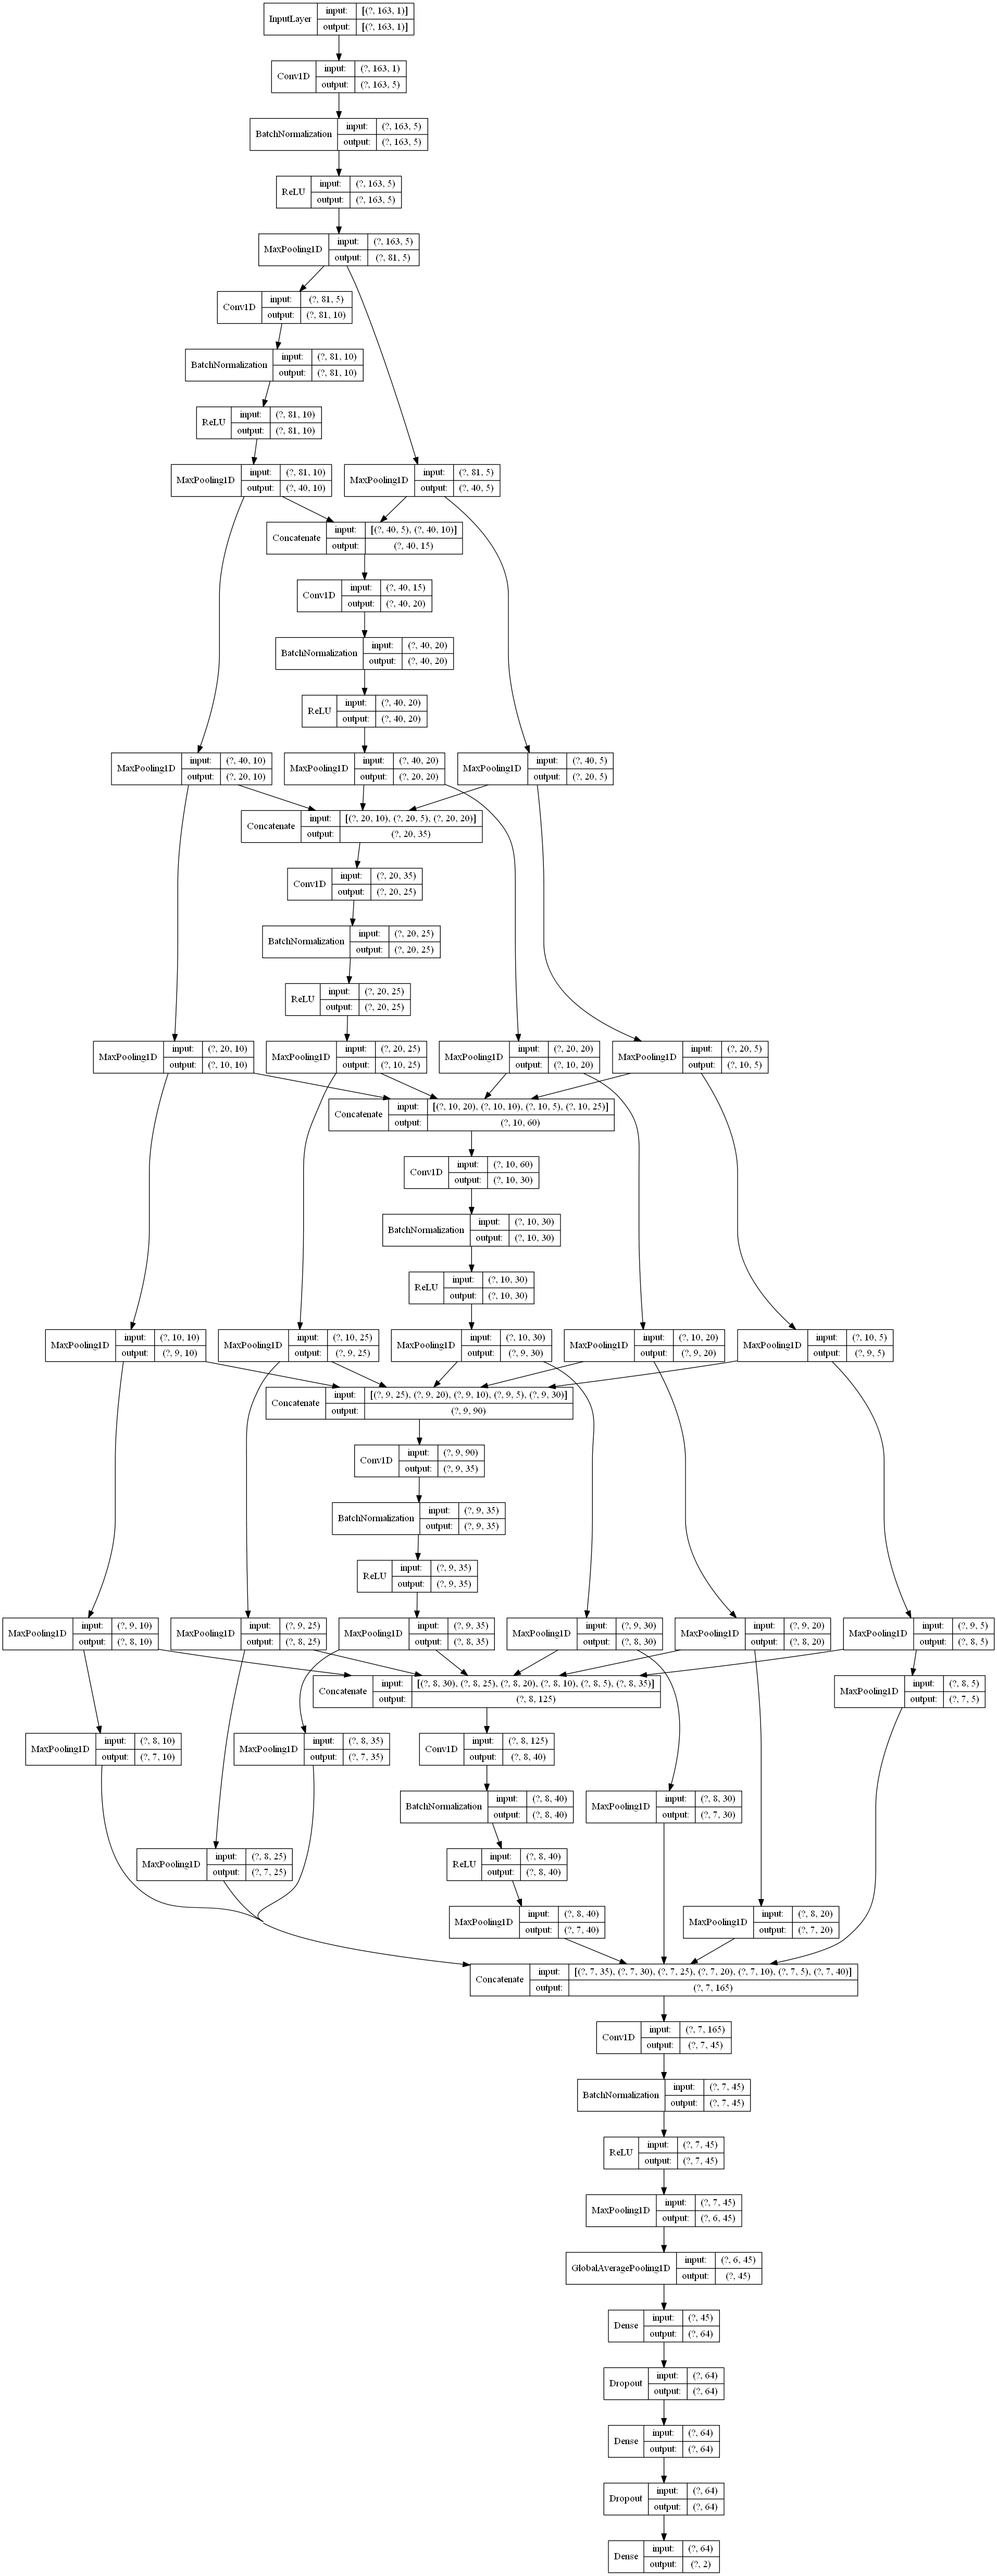

In [28]:
# Сomputational graph for Spider - 6
model_15 = spider_model_8block(drop_out_conv=None, drop_out_rate=None)
tf.keras.utils.plot_model(model_15, to_file='model.png',
                          show_shapes=True, show_layer_names=False, rankdir='TB')

In [29]:
#for Private
#training_generator = DataGenerator(train_for, x_col, y_col, batch_size=512, alpha=None, class_w=0.05)

In [53]:
#for Public
training_generator = DataGenerator(train_for, x_col, y_col, batch_size=512, alpha = None, class_w = 0.1 )
Y_test_2 = np_utils.to_categorical( y_val, 2) # преобразовываем в 2 класса 

In [30]:
initial_learning_rate = 0.005


def lr_step_decay(epoch, lr):
    drop_rate = 0.1
    epochs_drop = 20.0

    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

In [31]:
# Grid Search 8
gl_p = [False] #0
l2_batch = [ 0.0002] #1
n_ker = [5, 7] #2
n_fil = [ 5, 15] #3
d_hidden = [60, 100] #4
drop_out = [0.25] #5
drop_out_conv = [0.001] #6
reg_dense = [ 0.0002] #7
min_pool = [ 15] #7

In [338]:
param = itertools.product(gl_p, l2_batch, n_ker, n_fil, d_hidden)

0,model_spider8_internal_grid_20_7_5_64_0.0002_200515_2,"(False, 0.0002, 7, 5, 64, 0.25, 0.001, 0.0002, 20)",0.8251300936843902,0.07014745856378353,0.8448725437966713,0.06797556658189371

In [33]:
#for Private
#param = [(False, 0.0002, 7, 5, 64, 0.25, 0.001, 0.0002, 20)]

In [60]:
#for Public
#(False, 0.0002, 5, 15, 60, 0.25, 0.001, 0.0002, 15)
param = [(False, 0.0002, 5, 15, 60, 0.25, 0.001, 0.0002, 15, None, None),
         (False, 0.0002, 5, 15, 60, 0.25, 0.001, 0.0002, 15, 0.25, 0)
        ]

In [338]:
#param = itertools.product(gl_p, l2_batch, n_ker, n_fil, d_hidden)

In [55]:
inp_shape = X_2_2.shape[1]
inp_shape

128

In [61]:
VERBOSE = 2
BATCH_SIZE = 512
NB_EPOCH = 150
#class_weighting = {0:0.05 , 1:1}

#Public
class_weighting = {0:0.1 , 1:1}

result_all_8 = pd.DataFrame()
result_all_8['name_model'] = None
result_all_8['params'] = None
result_all_8['val_GINI'] = None
result_all_8['val_APS'] = None
result_all_8['test_GINI'] = None
result_all_8['test_APS'] = None
j = 0

for p in param:
    print('=====================================================================================================')
    print(inp_shape, X_2_2.shape, p)
    
    model_grid = spider_model_8block(reg = p[1], reg_dense = p[7], n_features = inp_shape, n_pool = 2, n_kernel = p[2], 
                              n_filters = p[3], n_strides = 1, classes = 2, 
                              hidden = p[4] , drop_out = p[5],
                 padding_pool = 'valid' , gl_pool_max = p[0], min_pool = p[8], str_pool = None, 
                                     drop_out_conv=p[9], drop_out_rate=p[10])
    
    model_grid.compile(loss='categorical_crossentropy', 
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
              metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
    
    history_XX = model_grid.fit_generator(generator=training_generator,  #training_aug,
                    validation_data= (X_2_2, Y_test_2) , #Y_test_2 = np_utils.to_categorical( y_val, 2) 
                                     epochs=NB_EPOCH, verbose=VERBOSE, class_weight=class_weighting,
                                     callbacks=[_time , EarlyStopping(monitor='val_loss', patience=20),
                                               Metrics(valid_data=(X_2_2, Y_test_2))])
    
    res_model_ = pd.DataFrame(history_XX.history, columns = history_XX.history.keys())
    dd = str(200000 + datetime.now().month*100 + datetime.now().day) + '_' + str(datetime.now().hour)
    name_m = 'model_spider8_internal_' +str(p[9]) + '_' + str(p[10]) + 't' + str(p[8]) + '_' + str(p[2]) + '_' + str(p[3]) + '_' + str(p[4]) + '_' + str(p[7]) + '_' + str(dd)
    
    model_grid.save( name_m + '.h5')
    res_model_.to_csv(name_m + '.csv')
    
    predict_class_val = model_grid.predict(X_2_2)
    APS = metrics.average_precision_score(y_val, predict_class_val[:,1])
    GINI = 2*(metrics.roc_auc_score(y_val , predict_class_val[:,1])) - 1

    predict_class_test = model_grid.predict(X_3_2)
    APS_t = metrics.average_precision_score(y_test, predict_class_test[:,1])
    GINI_t = 2*(metrics.roc_auc_score(y_test, predict_class_test[:,1])) - 1
    
    result_all_8.at[j , 'name_model'] = name_m
    result_all_8.at[j ,'params'] = str(p)
    result_all_8.at[j ,'val_GINI'] = GINI
    result_all_8.at[j ,'val_APS'] = APS
    result_all_8.at[j ,'test_GINI'] = GINI_t
    result_all_8.at[j ,'test_APS'] = APS_t
    
    result_all_8.to_csv('china_grid_result_all_8_test_dropconv_.csv')
    j += 1
    print(name_m, 'valid_for_train: ', GINI, APS, '| test: ', GINI_t, APS_t) 

128 (99001, 128) (False, 0.0002, 5, 15, 60, 0.25, 0.001, 0.0002, 15, None, None)
without dropout conv
without dropout conv
without dropout conv
without dropout conv
train_begin | time:  07.06.2021 11:57:57
Epoch 1/150
epoch_end | time:  07.06.2021 12:32:16
 — val_aps:  0.453282 — val_a: 0.972215
1547/1547 - 2082s - loss: 0.0443 - accuracy: 0.9542 - auc_4: 0.9881 - precision_4: 0.9542 - recall_4: 0.9542 - val_loss: 0.0441 - val_accuracy: 0.9871 - val_auc_4: 0.9982 - val_precision_4: 0.9871 - val_recall_4: 0.9871
Epoch 2/150
epoch_end | time:  07.06.2021 13:06:01
 — val_aps:  0.502915 — val_a: 0.975713
1547/1547 - 2023s - loss: 0.0174 - accuracy: 0.9760 - auc_4: 0.9936 - precision_4: 0.9760 - recall_4: 0.9760 - val_loss: 0.0812 - val_accuracy: 0.9786 - val_auc_4: 0.9936 - val_precision_4: 0.9786 - val_recall_4: 0.9786
Epoch 3/150
epoch_end | time:  07.06.2021 13:40:12
 — val_aps:  0.503998 — val_a: 0.974661
1547/1547 - 2049s - loss: 0.0150 - accuracy: 0.9788 - auc_4: 0.9951 - precision_4

Epoch 27/150
epoch_end | time:  08.06.2021 08:53:18
 — val_aps:  0.488050 — val_a: 0.963557
1547/1547 - 2722s - loss: 0.0078 - accuracy: 0.9875 - auc_4: 0.9987 - precision_4: 0.9875 - recall_4: 0.9875 - val_loss: 0.0616 - val_accuracy: 0.9830 - val_auc_4: 0.9961 - val_precision_4: 0.9830 - val_recall_4: 0.9830
Epoch 28/150
epoch_end | time:  08.06.2021 09:38:16
 — val_aps:  0.474332 — val_a: 0.963216
1547/1547 - 2695s - loss: 0.0079 - accuracy: 0.9874 - auc_4: 0.9987 - precision_4: 0.9874 - recall_4: 0.9874 - val_loss: 0.0631 - val_accuracy: 0.9782 - val_auc_4: 0.9971 - val_precision_4: 0.9782 - val_recall_4: 0.9782
Epoch 29/150
epoch_end | time:  08.06.2021 10:24:07
 — val_aps:  0.508436 — val_a: 0.970157
1547/1547 - 2751s - loss: 0.0077 - accuracy: 0.9877 - auc_4: 0.9988 - precision_4: 0.9877 - recall_4: 0.9877 - val_loss: 0.0708 - val_accuracy: 0.9737 - val_auc_4: 0.9964 - val_precision_4: 0.9737 - val_recall_4: 0.9737
Epoch 30/150
epoch_end | time:  08.06.2021 11:12:43
 — val_aps: 

Epoch 13/150
epoch_end | time:  09.06.2021 03:23:12
 — val_aps:  0.455019 — val_a: 0.969482
1547/1547 - 2953s - loss: 0.0113 - accuracy: 0.9825 - auc_5: 0.9975 - precision_5: 0.9825 - recall_5: 0.9825 - val_loss: 0.0488 - val_accuracy: 0.9859 - val_auc_5: 0.9974 - val_precision_5: 0.9859 - val_recall_5: 0.9859
Epoch 14/150
epoch_end | time:  09.06.2021 04:12:48
 — val_aps:  0.432127 — val_a: 0.953351
1547/1547 - 2975s - loss: 0.0111 - accuracy: 0.9826 - auc_5: 0.9976 - precision_5: 0.9826 - recall_5: 0.9826 - val_loss: 0.0481 - val_accuracy: 0.9894 - val_auc_5: 0.9964 - val_precision_5: 0.9894 - val_recall_5: 0.9894
Epoch 15/150
epoch_end | time:  09.06.2021 05:02:11
 — val_aps:  0.531115 — val_a: 0.972760
1547/1547 - 2960s - loss: 0.0110 - accuracy: 0.9824 - auc_5: 0.9976 - precision_5: 0.9824 - recall_5: 0.9824 - val_loss: 0.0632 - val_accuracy: 0.9780 - val_auc_5: 0.9970 - val_precision_5: 0.9780 - val_recall_5: 0.9780
Epoch 16/150
epoch_end | time:  09.06.2021 05:51:21
 — val_aps: 

Epoch 40/150
epoch_end | time:  10.06.2021 04:21:57
 — val_aps:  0.494432 — val_a: 0.970834
1547/1547 - 3139s - loss: 0.0089 - accuracy: 0.9857 - auc_5: 0.9985 - precision_5: 0.9857 - recall_5: 0.9857 - val_loss: 0.0495 - val_accuracy: 0.9843 - val_auc_5: 0.9975 - val_precision_5: 0.9843 - val_recall_5: 0.9843
Epoch 41/150
epoch_end | time:  10.06.2021 05:14:07
 — val_aps:  0.471304 — val_a: 0.964680
1547/1547 - 3127s - loss: 0.0087 - accuracy: 0.9859 - auc_5: 0.9985 - precision_5: 0.9859 - recall_5: 0.9859 - val_loss: 0.0490 - val_accuracy: 0.9872 - val_auc_5: 0.9971 - val_precision_5: 0.9872 - val_recall_5: 0.9872
Epoch 42/150
epoch_end | time:  10.06.2021 06:06:55
 — val_aps:  0.485063 — val_a: 0.968783
1547/1547 - 3165s - loss: 0.0085 - accuracy: 0.9861 - auc_5: 0.9986 - precision_5: 0.9861 - recall_5: 0.9861 - val_loss: 0.0670 - val_accuracy: 0.9815 - val_auc_5: 0.9959 - val_precision_5: 0.9815 - val_recall_5: 0.9815
Epoch 43/150
epoch_end | time:  10.06.2021 06:59:04
 — val_aps: 

In [42]:
predict_class_val = model_grid.predict(X_2_2)
APS = metrics.average_precision_score(y_test, predict_class_val[:, 1])
GINI = 2*(metrics.roc_auc_score(y_test, predict_class_val[:, 1])) - 1

predict_class_test = model_grid.predict(X_3_2)
APS_t = metrics.average_precision_score(y_val, predict_class_test[:, 1])
GINI_t = 2*(metrics.roc_auc_score(y_val, predict_class_test[:, 1])) - 1

In [43]:
result_all_8.at[j , 'name_model'] = name_m
result_all_8.at[j ,'params'] = str(p)
result_all_8.at[j ,'val_GINI'] = GINI
result_all_8.at[j ,'val_APS'] = APS
result_all_8.at[j ,'test_GINI'] = GINI_t
result_all_8.at[j ,'test_APS'] = APS_t
    
result_all_8.to_csv('internal_grid_result_all_8_wo_dropconv_.csv')
result_all_8

,name_model,params,val_GINI,val_APS,test_GINI,test_APS
0,model_spider8_internal_grid_wo_dropconv_20_7_5...,"(False, 0.0002, 7, 5, 64, 0.25, 0.001, 0.0002,...",0.827039,0.0545976,0.842407,0.0464484


## SpiderNet-8

In [56]:
def spider_model_8block(l2_conv = None, reg = 1E-5 , reg_dense = 1E-5,
                 _bias = True,  n_features = 163, n_pool = 2, n_kernel = 5, n_filters = 5, n_strides = 1,
                 classes = 2, hidden = 64 , drop_out = 0.25, drop_out_conv = 0.001, drop_out_rate = 4 ,
                 padding_pool = 'valid' ,
                gl_pool_max = False,
                       min_pool = 12, str_pool = None):
    
    if reg == None:
        l2_batch_gamma = None 
        l2_batch_betta = None
    else:
        l2_batch_gamma = l2(reg)
        l2_batch_betta =l2(reg)
    
    if reg_dense == None:
        kernel_regularizer = None
    else:
        kernel_regularizer = l2(reg)   
    
    
    x = Input(shape=(  n_features, 1))
    n = -2 # для 6 - n = 0, для 8 = -2
    y = Conv1D(filters=n_filters, kernel_size=n_kernel, strides=n_strides, padding='same', 
           use_bias=_bias, kernel_regularizer=l2_conv)(x) 

    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)
#y = Dropout(rate=drop_rate)(y)

    y = max_pool(min_pool, n_pool, padding_pool, str_pool, y) ##
    shortcut1_2 = max_pool(min_pool, n_pool, padding_pool, str_pool, y)## поправить
    shortcut1_3 = max_pool(min_pool, n_pool, padding_pool, str_pool, shortcut1_2)##
    shortcut1_4 = max_pool(min_pool, n_pool, padding_pool, str_pool, shortcut1_3)##
    
    shortcut1_5 = max_pool(min_pool, n_pool, padding_pool, str_pool, shortcut1_4)
    shortcut1_6 = max_pool(min_pool, n_pool, padding_pool, str_pool, shortcut1_5) #*
    shortcut1_7 = max_pool(min_pool, n_pool, padding_pool, str_pool, shortcut1_6) #*

    # второй spider-block
    y = Conv1D(filters=n_filters*2, kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y = max_pool(min_pool, n_pool, padding_pool, str_pool, y) ##
    shortcut2_3 = max_pool(min_pool, n_pool, padding_pool, str_pool, y)##
    shortcut2_4 = max_pool(min_pool, n_pool, padding_pool, str_pool, shortcut2_3)##
    
    shortcut2_5 = max_pool(min_pool, n_pool, padding_pool, str_pool, shortcut2_4)
    shortcut2_6 = max_pool(min_pool, n_pool, padding_pool, str_pool, shortcut2_5)
    shortcut2_7 = max_pool(min_pool, n_pool, padding_pool, str_pool, shortcut2_6)


    y= Concatenate(axis=-1)([shortcut1_2, y])
    n = n+1

    # третий spider-block
    y = Conv1D(filters=n_filters*(3 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y = max_pool(min_pool, n_pool, padding_pool, str_pool, y) ##
    shortcut3_4 = max_pool(min_pool, n_pool, padding_pool, str_pool, y)##
    
    shortcut3_5 = max_pool(min_pool, n_pool, padding_pool, str_pool, shortcut3_4)##
    shortcut3_6 = max_pool(min_pool, n_pool, padding_pool, str_pool, shortcut3_5)##
    shortcut3_7 = max_pool(min_pool, n_pool, padding_pool, str_pool, shortcut3_6)##

    y= Concatenate(axis=-1)([shortcut2_3, shortcut1_3, y])
    
    n = n+1
    # четвертый spider-block
    y = Conv1D(filters=n_filters*(4 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y = max_pool(min_pool, n_pool, padding_pool, str_pool, y) ##
    shortcut4_5 = max_pool(min_pool, n_pool, padding_pool, str_pool, y)##
    shortcut4_6 = max_pool(min_pool, n_pool, padding_pool, str_pool, shortcut4_5)##
    shortcut4_7 = max_pool(min_pool, n_pool, padding_pool, str_pool, shortcut4_6)##

    y= Concatenate(axis=-1)([shortcut3_4, shortcut2_4, shortcut1_4, y])
    n = n+1
    if drop_out_rate is not None:
        y = Dropout(drop_out_conv*(n**drop_out_rate))(y)
        print(n, drop_out_conv*(n**drop_out_rate))
    elif drop_out_rate == 0:
        y = Dropout(drop_out_conv)(y)
        print(n, drop_out_conv)
    else:
        print('without dropout conv')

    # пятый spider-block
    y = Conv1D(filters=n_filters*(5 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y = max_pool(min_pool, n_pool, padding_pool, str_pool, y) ##
    shortcut5_6 = max_pool(min_pool, n_pool, padding_pool, str_pool, y)
    shortcut5_7 = max_pool(min_pool, n_pool, padding_pool, str_pool, shortcut5_6)    
    
    
    y= Concatenate(axis=-1)([shortcut4_5, shortcut3_5, shortcut2_5, shortcut1_5, y])
    n = n+1
    if drop_out_rate is not None:
        y = Dropout(drop_out_conv*(n**drop_out_rate))(y)
        print(n, drop_out_conv*(n**drop_out_rate))
    elif drop_out_rate == 0:
        y = Dropout(drop_out_conv)(y)
        print(n, drop_out_conv)
    else:
        print('without dropout conv')

    # шестой spider-block
    y = Conv1D(filters=n_filters*(6 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)
    
    y = max_pool(min_pool, n_pool, padding_pool, str_pool, y) ##
    shortcut6_7 = max_pool(min_pool, n_pool, padding_pool, str_pool, y)
    
    y= Concatenate(axis=-1)([shortcut5_6, shortcut4_6, shortcut3_6, shortcut2_6, shortcut1_6, y])
    n = n+1
    if drop_out_rate is not None:
        y = Dropout(drop_out_conv*(n**drop_out_rate))(y)
        print(n, drop_out_conv*(n**drop_out_rate))
    elif drop_out_rate == 0:
        y = Dropout(drop_out_conv)(y)
        print(n, drop_out_conv)
    else:
        print('without dropout conv')
    
    
    # седьмой блок
    y = Conv1D(filters=n_filters*(7 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)
    
    y = max_pool(min_pool, n_pool, padding_pool, str_pool, y) ##
    
    y= Concatenate(axis=-1)([shortcut6_7, shortcut5_7, shortcut4_7, shortcut3_7, shortcut2_7, shortcut1_7, y])
    n = n+1
    if drop_out_rate is not None:
        y = Dropout(drop_out_conv*(n**drop_out_rate))(y)
        print(n, drop_out_conv*(n**drop_out_rate))
    elif drop_out_rate == 0:
        y = Dropout(drop_out_conv)(y)
        print(n, drop_out_conv)
    else:
        print('without dropout conv')
            
    
     # восьмой блок
    y = Conv1D(filters=n_filters*(8 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)
    
    y = max_pool(min_pool, n_pool, padding_pool, str_pool, y) ##
    
    if gl_pool_max:
        z = GlobalMaxPooling1D()(y)
        
    else:
        z = GlobalAveragePooling1D()(y)
    #z = Flatten()(y) #сглаживание, пример использования - https://stackoverflow.com/questions/43237124/what-is-the-role-of-flatten-in-keras
    z = Dense(hidden, activation='relu', kernel_regularizer = kernel_regularizer)(z)
    z = Dropout(drop_out)(z)
    z = Dense(hidden, activation='relu', kernel_regularizer = kernel_regularizer)(z)
    z = Dropout(drop_out)(z)
    predictions = Dense(classes, activation='softmax')(z)

    #model = Sequential()
    model_15 = Model(inputs=x, outputs=predictions)
    
    return model_15

In [46]:
VERBOSE = 2
BATCH_SIZE = 512
NB_EPOCH = 150
class_weighting = {0:0.05 , 1:1}

j = 1

for p in param:
    print('=====================================================================================================')
    print(inp_shape, X_2_2.shape, p)
    
    model_grid = spider_model_8block(reg = p[1], reg_dense = p[7], n_features = inp_shape, n_pool = 2, n_kernel = p[2], 
                              n_filters = p[3], n_strides = 1, classes = 2, 
                              hidden = p[4] , drop_out = p[5],
                 padding_pool = 'valid' , gl_pool_max = p[0], min_pool = p[8], str_pool = None, 
                                     drop_out_conv=0.25, drop_out_rate=0)
    
    model_grid.compile(loss='categorical_crossentropy', 
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
              metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
    
    history_XX = model_grid.fit_generator(generator=training_generator,  #training_aug,
                    validation_data= (X_2_2, Y_test_2) , #Y_test_2 = np_utils.to_categorical( y_val, 2) 
                                     epochs=NB_EPOCH, verbose=VERBOSE, class_weight=class_weighting,
                                     callbacks=[_time , EarlyStopping(monitor='val_loss', patience=20),
                                               Metrics(valid_data=(X_2_2, Y_test_2))])
    
    res_model_ = pd.DataFrame(history_XX.history, columns = history_XX.history.keys())
    dd = str(200000 + datetime.now().month*100 + datetime.now().day) + '_' + str(datetime.now().hour)
    name_m = 'model_spider8_internal_grid_dropconst_0.25' + str(p[8]) + '_' + str(p[2]) + '_' + str(p[3]) + '_' + str(p[4]) + '_' + str(p[7]) + '_' + str(dd)
    
    model_grid.save( name_m + '.h5')
    res_model_.to_csv(name_m + '.csv')
    
    predict_class_val = model_grid.predict(X_2_2)
    APS = metrics.average_precision_score(y_test, predict_class_val[:, 1])
    GINI = 2*(metrics.roc_auc_score(y_test, predict_class_val[:, 1])) - 1

    predict_class_test = model_grid.predict(X_3_2)
    APS_t = metrics.average_precision_score(y_val, predict_class_test[:, 1])
    GINI_t = 2*(metrics.roc_auc_score(y_val, predict_class_test[:, 1])) - 1
    
    result_all_8.at[j , 'name_model'] = name_m
    result_all_8.at[j ,'params'] = str(p)
    result_all_8.at[j ,'val_GINI'] = GINI
    result_all_8.at[j ,'val_APS'] = APS
    result_all_8.at[j ,'test_GINI'] = GINI_t
    result_all_8.at[j ,'test_APS'] = APS_t
    
    result_all_8.to_csv('internal_grid_result_all_8_wo_dropconv_.csv')
    j += 1
    print(name_m, 'valid_for_train: ', GINI, APS, '| test: ', GINI_t, APS_t) 

163 (185400, 163) (False, 0.0002, 7, 5, 64, 0.25, 0.001, 0.0002, 20)
1 0.25
2 0.25
3 0.25
4 0.25
train_begin | time:  03.06.2021 19:44:33
Epoch 1/150
epoch_end | time:  03.06.2021 20:04:03
 — val_aps:  0.051093 — val_a: 0.888787
2945/2945 - 1206s - loss: 0.0153 - accuracy: 0.9726 - auc_3: 0.9940 - precision_3: 0.9726 - recall_3: 0.9726 - val_loss: 0.7373 - val_accuracy: 0.7957 - val_auc_3: 0.8301 - val_precision_3: 0.7957 - val_recall_3: 0.7957
Epoch 2/150
epoch_end | time:  03.06.2021 20:24:10
 — val_aps:  0.058759 — val_a: 0.939364
2945/2945 - 1203s - loss: 0.0074 - accuracy: 0.9860 - auc_3: 0.9973 - precision_3: 0.9860 - recall_3: 0.9860 - val_loss: 0.0840 - val_accuracy: 0.9773 - val_auc_3: 0.9967 - val_precision_3: 0.9773 - val_recall_3: 0.9773
Epoch 3/150
epoch_end | time:  03.06.2021 20:44:03
 — val_aps:  0.072053 — val_a: 0.934020
2945/2945 - 1194s - loss: 0.0068 - accuracy: 0.9868 - auc_3: 0.9978 - precision_3: 0.9868 - recall_3: 0.9868 - val_loss: 0.0465 - val_accuracy: 0.991

Epoch 27/150
epoch_end | time:  04.06.2021 04:23:03
 — val_aps:  0.080816 — val_a: 0.931811
2945/2945 - 1138s - loss: 0.0046 - accuracy: 0.9893 - auc_3: 0.9990 - precision_3: 0.9893 - recall_3: 0.9893 - val_loss: 0.0220 - val_accuracy: 0.9958 - val_auc_3: 0.9994 - val_precision_3: 0.9958 - val_recall_3: 0.9958
Epoch 28/150
epoch_end | time:  04.06.2021 04:41:51
 — val_aps:  0.074009 — val_a: 0.904590
2945/2945 - 1127s - loss: 0.0047 - accuracy: 0.9893 - auc_3: 0.9989 - precision_3: 0.9893 - recall_3: 0.9893 - val_loss: 0.0187 - val_accuracy: 0.9969 - val_auc_3: 0.9983 - val_precision_3: 0.9969 - val_recall_3: 0.9969
Epoch 29/150
epoch_end | time:  04.06.2021 05:00:44
 — val_aps:  0.080105 — val_a: 0.930924
2945/2945 - 1133s - loss: 0.0046 - accuracy: 0.9895 - auc_3: 0.9990 - precision_3: 0.9895 - recall_3: 0.9895 - val_loss: 0.0200 - val_accuracy: 0.9949 - val_auc_3: 0.9990 - val_precision_3: 0.9949 - val_recall_3: 0.9949
Epoch 30/150
epoch_end | time:  04.06.2021 05:19:37
 — val_aps: 